In [2]:
import ast
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from mlxtend.plotting import plot_decision_regions

import numpy as np

import pandas as pd
# pd.options.display.max_columns = None
# pd.set_option('display.max_rows', 500)

import os
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots

import seaborn as sns

import re

from sklearn import datasets
from sklearn.datasets import( load_iris, load_digits, fetch_lfw_people )
from sklearn.ensemble import( AdaBoostClassifier, AdaBoostRegressor, ExtraTreesClassifier, 
                              GradientBoostingClassifier,RandomForestClassifier, StackingClassifier )

from sklearn.feature_selection import f_regression
from sklearn.pipeline import Pipeline
from sklearn.impute import( KNNImputer, SimpleImputer )
from sklearn.preprocessing import( OneHotEncoder, StandardScaler, LabelEncoder, PolynomialFeatures )
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import( LogisticRegression, LinearRegression, Ridge, Lasso )
from sklearn.model_selection import( cross_val_score, GridSearchCV, StratifiedShuffleSplit, train_test_split )
from sklearn.metrics import( accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, 
                             f1_score, mean_squared_error, r2_score, RocCurveDisplay )

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import ( DecisionTreeClassifier, DecisionTreeRegressor )
from sklearn.utils import resample

from scipy.stats import mode 

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import sys    
import warnings

warnings.filterwarnings( "ignore", category=DeprecationWarning ) # to avoid deprecation warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template( layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6",
                                                              "#2A7FAF", "#23B1AB", "#0E3449", "#015955"] )
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JUPITER or "iframe_connected" or "notebook"

from xgboost import XGBRegressor




In [3]:
dataset = pd.read_csv('src/dataset_clear.csv')
dataset.head(5)

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Day,DayOfWeek
0,store 1,1643690.90,No,42.31,2.572,211.096358,8.106,2010,5,2,Sunday
1,store 1,1641957.44,No,38.51,2.548,211.242170,8.106,2010,12,2,Thursday
2,store 1,1611968.17,No,39.93,2.514,211.289143,8.106,2010,2,19,Friday
3,store 1,1409727.59,No,46.63,2.561,211.319643,8.106,2010,2,26,Friday
4,store 1,1554806.68,No,46.50,2.625,211.350143,8.106,2010,5,3,Monday


In [4]:
 # - Categorical variables : Store, Holiday_Flag
 # - Numerical variables : Temperature, Fuel_Price, CPI, Unemployment, Year, Month, Day, DayOfWeek
dataset.dtypes

Store            object
Weekly_Sales    float64
Holiday_Flag     object
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
Year              int64
Month             int64
Day               int64
DayOfWeek        object
dtype: object

## Graph de correlation 

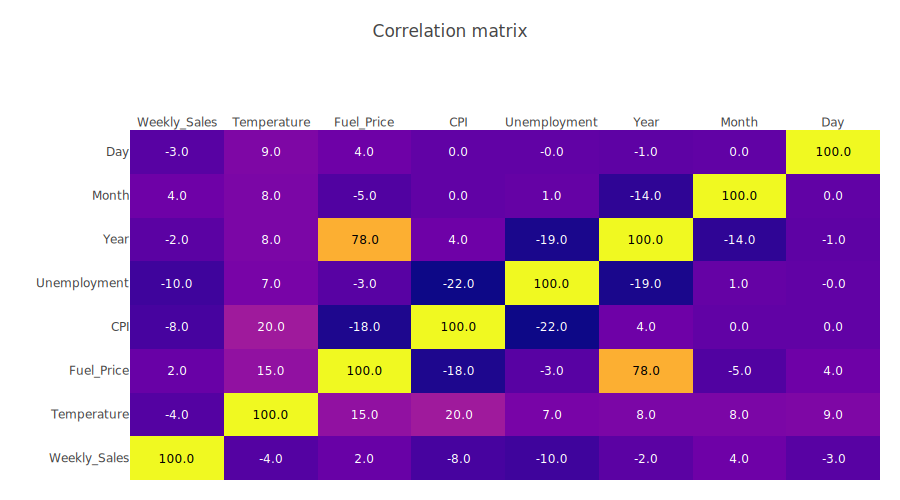

In [5]:
# Correlation matrix
corr_matrix = round(dataset.corr()*100)

from turtle import width
import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.values.tolist(),
                                  y = corr_matrix.index.values.tolist())

fig.update_layout(
           title = go.layout.Title(text = "Correlation matrix", x = 0.5, y=0.95), showlegend = False,
                autosize=False, width=900, height=500, margin=dict(l=130, r=20, t=130, b=20))

fig.show()

## Préprocessing Pipeline

In [6]:
def preprocessing_pipeline(X):
    # Create pipeline for numeric features
    numeric_features = X.select_dtypes([np.number]).columns # Automatically detect positions of numeric columns
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
        ('scaler', StandardScaler())
    ])

    # Create pipeline for categorical features
    categorical_features = X.select_dtypes("object").columns # Automatically detect positions of categorical columns
    categorical_transformer = Pipeline(
        steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
        ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
        ])

    # Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    return preprocessor


In [7]:
# https://alfurka.github.io/2018-11-18-grid-search/
def test(models, dataset, iterations = 100, target_name = 'Weekly_Sales'):

    Y = dataset[:][target_name]
    X = dataset.drop(columns= [target_name])

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

    preprocessor = preprocessing_pipeline(X)

    X_train = preprocessor.fit_transform(X_train) # Preprocessing influenceur
    X_test = preprocessor.transform(X_test) # Preprocessing copieur

    results = {}
    for i in models:
        r2_train = []
        r2_test = []
        for j in range(iterations): 
            r2_test.append(r2_score(Y_test, models[i].fit(X_train, Y_train).predict(X_test)))
            r2_train.append(r2_score(Y_train, models[i].fit(X_train, Y_train).predict(X_train)))

        results[i] = [np.mean(r2_train), np.mean(r2_test)]
    return pd.DataFrame(results)
'''
models = {'OLS': LinearRegression(),
         'Lasso': Lasso(),
         'Ridge': Ridge()}

test(models, dataset)
'''
lasso_params = {'fit__alpha':[0.005, 0.02, 0.03, 0.05, 0.06]}
ridge_params = {'fit__alpha':[550, 580, 600, 620, 650]}

target_name = 'Weekly_Sales'
Y = dataset[:][target_name]
X = dataset.drop(columns= [target_name])
X = preprocessing_pipeline(X).fit_transform(X)

pipe1 = Pipeline([('poly', PolynomialFeatures()), ('fit', LinearRegression())])
pipe2 = Pipeline([('poly', PolynomialFeatures()), ('fit', Lasso())])
pipe3 = Pipeline([('poly', PolynomialFeatures()), ('fit', Ridge())])

models3 = {'OLS': pipe1,
           'Lasso': GridSearchCV(pipe2, param_grid=lasso_params, n_jobs = -1).fit(X, Y).best_estimator_ ,
           'Ridge': GridSearchCV(pipe3, param_grid=ridge_params, n_jobs = -1).fit(X, Y).best_estimator_}

test(models3, dataset)


,OLS,Lasso,Ridge
0,0.964151,0.963265,0.602662
1,0.956653,0.957684,0.584632
